# **Assignment 3:** Clustering

### **Worked hours:** ...
### **Authors:** Sidner Magnéli, Lukas Martinsson 


These questions concern the main conformation of proteins. Part of a protein's main chain is
shown in Figure 1. A protein chain is able to fold into its native conformation by rotation
around two of the bonds in the main chain, designated f (phi) and y (psi). Some combinations
of phi and psi are impossible (e.g. some atoms clash into each other if we try to force the main
chain to have a particular combination of phi and psi). Some other combinations of phi and
psi are very common since they are energetically favourable. To understand the problem
domain better, please look at:

• http://bioinformatics.org/molvis/phipsi/

• http://tinyurl.com/RamachandranPrincipleYouTube

The provided data file contains a list of phi and psi combinations that have been observed in
proteins. The angles are measured here in degrees.
___

In [ ]:
# global imports and configuration
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set plot style
sns.set_style("darkgrid")
# plt.style.use('seaborn')

CMAP = 'viridis'

### **Load dataset**

In [ ]:
df_raw = pd.read_csv('./datasets/data_all.csv')
df_raw.head(5)

,residue name,position,chain,phi,psi
0,LYS,10,A,-149.312855,142.657714
1,PRO,11,A,-44.283210,136.002076
2,LYS,12,A,-119.972621,-168.705263
3,LEU,13,A,-135.317212,137.143523
4,LEU,14,A,-104.851467,95.928520


Remove any rows with only NaN values

In [ ]:
df = df_raw.dropna(how='all')

## **Part 1:** Show the distribution of phi and psi combinations using:

### **1.a)** A scatter plot

No handles with labels found to put in legend.


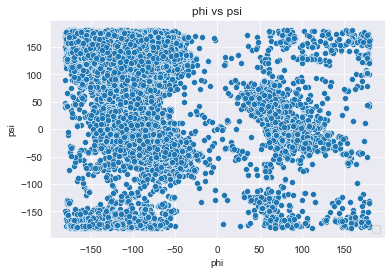

In [ ]:
# create scatter plot
ax = sns.scatterplot(x=df['phi'],y=df['psi'],legend=True)
ax.set_title('phi vs psi')
ax.legend(loc="lower right")

### **1.b)** A heat map

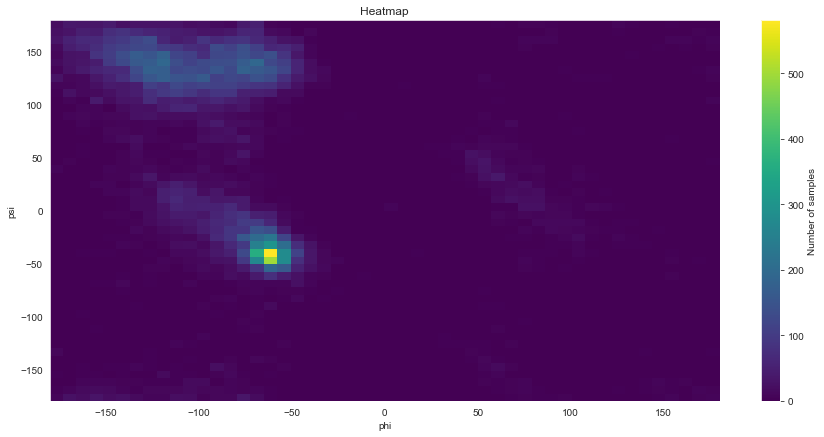

In [ ]:
# create heat map
plt.figure(figsize=(15, 7))
plt.hist2d(df['phi'],df['psi'], bins=50, cmap=CMAP)

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of samples')

# plot configs
plt.xlabel('phi'); plt.ylabel('psi')
plt.title('Heatmap')
plt.show()

## **Part 2**: Use the K-means clustering method to cluster the phi and psi angle combinations in the data file

In [ ]:
from sklearn.cluster import KMeans

# pick input features
X = df.loc[:,['phi', 'psi']]

### **2.a)** Experiment with different values of K. Suggest an appropriate value of K for this task and motivate this choice.

We show the clustering by generating scatterplots for increasing values of **k**.

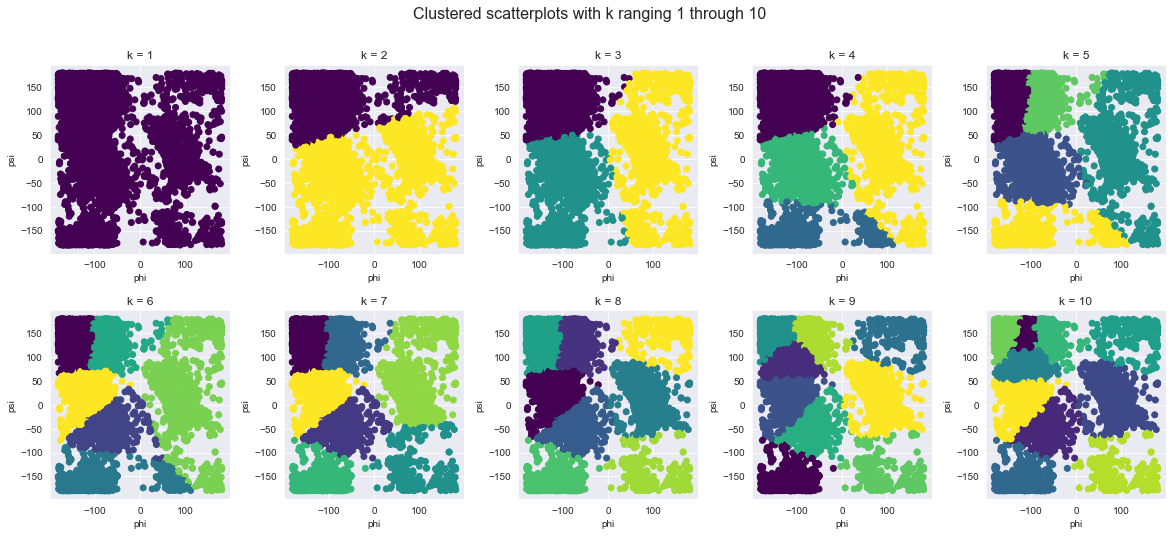

In [11]:
ks = range(1,11)
mean_squared_error = []

i,j=0,0
fig, axs = plt.subplots(2,5, figsize=(20, 8))
for k in ks:
  # create and train model
  kmean_model = KMeans(n_clusters=k, random_state=0).fit(X)
  
  # predict clusters 
  y_pred = kmean_model.predict(X)

  # store mean squared error / k for elbow plot
  mean_squared_error.append(kmean_model.inertia_)

  axs[i][j].scatter(x=X['phi'],y=X['psi'],c=y_pred,cmap=CMAP)
  axs[i][j].set_xlabel('phi\n')
  axs[i][j].set_ylabel('psi')
  axs[i][j].set_title(f'k = {k}')

  j+=1
  if j%5==0:
      i+=1
      j=0

plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Clustered scatterplots with k ranging 1 through 10', fontsize=16)
plt.show()

By looking at the scatterplot for different k values we can see several things. Firstly when k=2 we can se that the data points are more denssly gathered in the right upper left corner. This would not have been our original guess if we were to visually create 2 clusters.
And altough the centers slightly each time the cluster method is run since the starting points may vary it still gives a clear indicator of when the k value reaches an apporpriate value.
By looking att the differents between K=3 and K=4 visually the clusters are better when k=3. However k=5 also has reasonable clusters. So it is hard to say visually, therefore we also want to make use of the elbow method. By combining what we can see visually and through the elbow method, we can give a better suggestion of an apporiate K

Generate an elbow plot to help determine the optimal **k** value (number of of clusters).

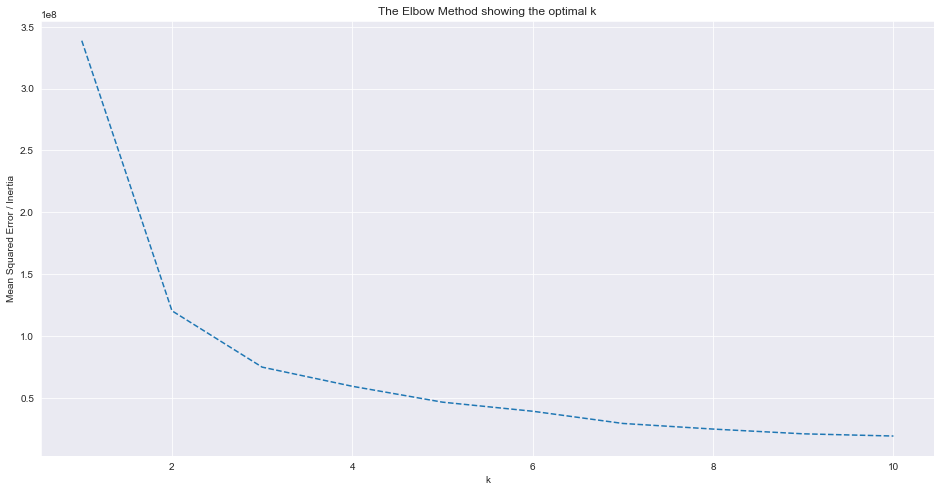

In [12]:
plt.figure(figsize=(16,8))
plt.plot(ks, mean_squared_error, '--')
plt.xlabel('k')
plt.ylabel('Mean Squared Error / Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Looking at the elbow plot the rate of mean square error we can se that the largest change occurs at 2 and 3. Afterwards the change is more or less constant from 3 to 7. Therefore by combining what we saw, combined with the fact that the cluster may vary depending on the starting points and that the clusters in the right corners are spares (which will indicate that when we remove a percentage of data to validate those cluster will not be as prononced) we would chose k=3 or k=4. More discussion concering this will follow in 2b since there we will be discussin the correlation between a modifided set compared to the original

### **2.b)** *Validate the clusters that are found with the chosen value of K. Hint: See the slides for Lecture 6, Section Validating clustering.*)*   

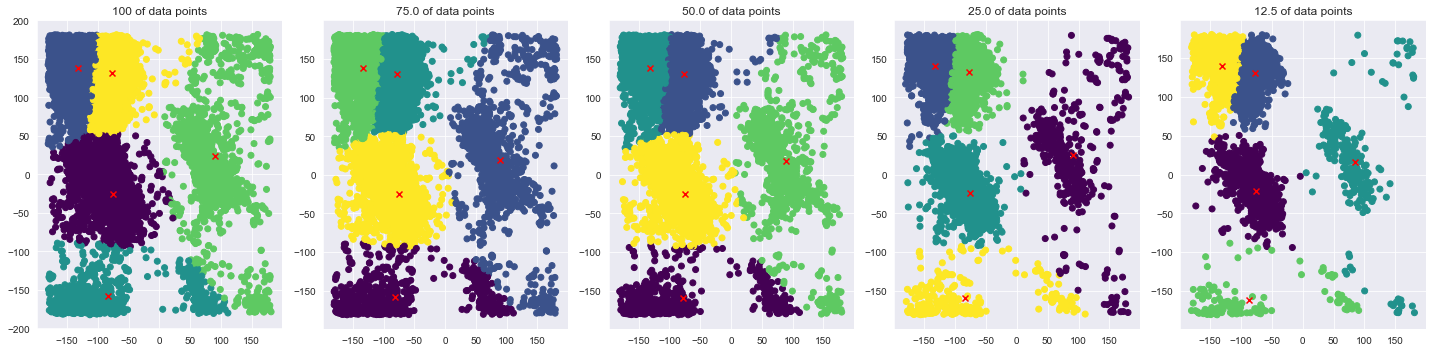

In [13]:
from sklearn.datasets import make_blobs

k_optimal = 5
sample_limits = [1,0.75,0.5,0.25,0.125]
fig, axs = plt.subplots(1, len(sample_limits), figsize=(20,5))

for i in range(0,len(sample_limits)):
    # varying the number of samples enables ut to demonstrate the difference in the selected centriods
    n_samples = int(len(X)*sample_limits[i])

    # makes n_samples blobs
    X_blob, _ = make_blobs(n_samples=n_samples, centers=X)

    # Fitting the data and specifying the clusters to 5 and predicting the kmean in each dataset
    model_kmeans = KMeans(n_clusters=k_optimal, random_state=0).fit(X_blob)
    y_pred = model_kmeans.predict(X_blob)
    
    axs[i].scatter(X_blob[:,0], X_blob[:,1], c=y_pred, cmap=CMAP)

    # Plots the data  
    axs[i].scatter(model_kmeans.cluster_centers_[:, 0], model_kmeans.cluster_centers_[:, 1], marker='x',c='red')
    axs[i].set_title(f'{sample_limits[i]*100} of data points')

plt.tight_layout()
plt.show()

Probably the easiest way to remove an appropriate amount of datapoints it by using a percentage of the whole dataframe. Therefor it would be resonable to use 100%,75%,50%,25% and 12,5% to see how the different cluster change. Since its hard to find an appropriate k just by the elbow method and whatching the scatterplot visualy 

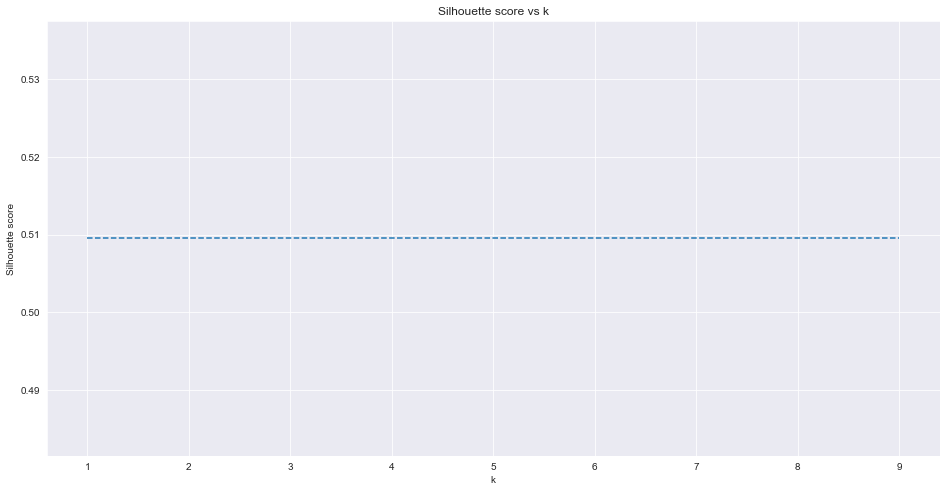

In [14]:
from sklearn.metrics import silhouette_score
silhouette_score_list = []
ks = range(2,10)
for k in ks:
  model_kmeans = KMeans(n_clusters=k_optimal, random_state=0).fit(X)

  # get silhouette score for different k values
  score = silhouette_score(X,model_kmeans.labels_,random_state=0)
  silhouette_score_list.append(score)

plt.figure(figsize=(16,8))
plt.plot(ks, silhouette_score_list, '--')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs k')
plt.show()

### **2.c)** *Do the clusters found in part **(a)** seem reasonable?*

### **2.d)** Can you change the data to get better results (or the same results in a simpler way)? (Hint: since both phi and psi are periodic attributes, you can think of shifting/translating them by some value and then use the modulo operation.)

## **Part 3**: Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.

In [15]:
# import relevant libraries
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

Since 3.a and 3.b want to have a motivation of why we chose different variables such as eps we have to be able to analyze different values for these to motivate our decision.

TypeError: '(slice(None, None, None), 0)' is an invalid key

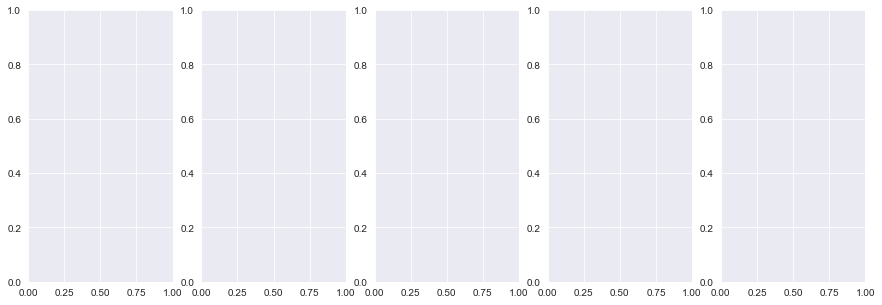

In [17]:

# Choosing sample and eps values
min_samples = [150,175,200,225,250]
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
length_samples = len(min_samples)
length_eps = len(eps)

for i in range(0, length_eps):
    fig, ax = plt.subplots(1, length_samples, figsize=(15,5))
    for j in range (0, length_samples):
        
        # Compute DBSCAN with the different values
        db = DBSCAN(eps=eps[i], min_samples=min_samples[j]).fit(X)
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 

        y_pred = db.fit_predict(X)

        ax[j].scatter(X[:,0], X[:,1],c=y_pred, cmap=CMAP)
        ax[j].set_title('Epsilon=%d', 'Cluster=%d', 'min_sample=%d', 'Noise points=%d' %(eps[i], n_clusters_, min_samples[j],n_noise_))

n_samples = 1000
X_blob, _ = make_blobs(n_samples=n_samples, centers=X)

plt.tight_layout()
plt.show()

### **3.a)** Motivate:

* **i)** the choice of the minimum number of samples in the neighborhood for a point to be considered as a core point, and


* **ii)** the choice of the maximum distance between two samples belonging to the same neighbourhood (“eps” or “epsilon”).

### **3.b)** Highlight the clusters found using DBSCAN and any outliers in a scatter plot. How many outliers are found? Plot a bar chart to show which amino acid residue types are most frequently outliers.

### **3.c)** Compare the clusters found by DBSCAN with those found using K-means.

### **3.d)** Discuss whether the clusters found using DBSCAN are robust to small changes in the minimum number of samples in the neighbourhood for a point to be considered as a core point, and/or the choice of the maximum distance between two samples belonging to the same neighbourhood (“eps” or “epsilon”).

## **Part 4**: The data file can be stratified by amino acid residue type. 
Remember that when doing clustering using DBSCAN for a) and b) here, the parameters might have to be adjusted from those used in previous questions.

### **4.a)** Use DBSCAN to cluster the data that have residue type PRO. Investigate how the clusters found for amino acid residues of type PRO differ from the general clusters (i.e., the clusters that you get from DBSCAN with mixed residue types in question 3).

### **4.b)** Now use DBSCAN to cluster the data that have residue type GLY. Investigate how the clusters found for amino acid residues of type GLY differ from the general clusters.